In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')


In [2]:
def plot_perf_file(filepath, cache_levels, is_vm, df_host = None):
    df = pd.read_csv(filepath, comment='#', header=None, 
                     names=['time', 'counter_value', 'event_name'],
                     usecols=[0, 1, 3])
    cache_df = df[df['event_name'].isin(cache_levels)].copy()
    if cache_df.empty:
        print(f"Empty data for {filepath}")
        return None

    if is_vm:
        walker_hits = df_host[df_host['event_name'].str.startswith('page_walker_loads.dtlb_l')]['counter_value'].sum() + \
                      df_host[df_host['event_name'] == 'page_walker_loads.dtlb_memory:u']['counter_value'].sum()
        miss_causes_walk = df_host[df_host['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum()
        ratio = max(0, (walker_hits / miss_causes_walk) - 1) if miss_causes_walk != 0 else 0
        time_groups = cache_df.groupby('time')
        for time, group in time_groups:
            mask = (cache_df['time'] == time) & (cache_df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u')
            cache_df.loc[mask, 'counter_value'] *= (1/2 - ratio/6)

    cache_df.loc[:, 'vm'] = 'With VM' if is_vm else 'Without VM'
    return cache_df

def get_final_df(dir1, dir2, quantities):
    quantities += ['dtlb_load_misses.miss_causes_a_walk:u', 'page_walker_loads.dtlb_l1:u', 'page_walker_loads.dtlb_l2:u', 'page_walker_loads.dtlb_l3:u', 'page_walker_loads.dtlb_memory:u']
    perf_files1 = [os.path.join(dir1, f) for f in os.listdir(dir1) if f.endswith('.perf')]
    perf_files2 = [os.path.join(dir2, f) for f in os.listdir(dir2) if f.endswith('.perf')]

    hosts = {}
    dataframes = []
    for p1 in perf_files1:
        df1 = plot_perf_file(p1, quantities, False)
        if df1 is not None:
            workload = os.path.basename(p1).split('.')[0] 
            df1['workload'] = workload
            hosts[workload] = df1

    for p2 in perf_files2:
        workload = os.path.basename(p2).split('.')[0] 
        if workload in hosts:
            df1 = hosts[workload]
            df2 = plot_perf_file(p2, quantities, True, df1)
            if df2 is not None:
                dataframes.append(df1)
                df2['workload'] = workload
                dataframes.append(df2)
    return pd.concat(dataframes)


Empty data for ./perf_output/out2/cc-road.1.perf
Empty data for ./perf_output/out_vm2/pr-road.1.perf


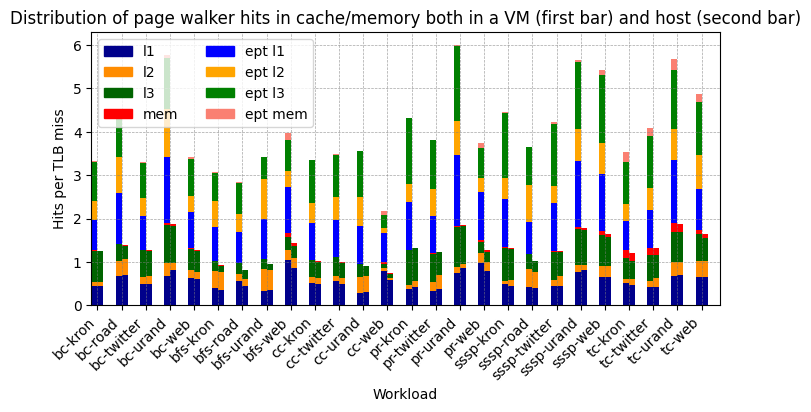

In [3]:
directory_path1 = './perf_output/out2'
directory_path2 = './perf_output/out_vm2'

quantities = [
    'page_walker_loads.dtlb_l1:u', 
    'page_walker_loads.dtlb_l2:u', 
    'page_walker_loads.dtlb_l3:u', 
    'page_walker_loads.dtlb_memory:u',
    'page_walker_loads.ept_dtlb_l1:u', 
    'page_walker_loads.ept_dtlb_l2:u', 
    'page_walker_loads.ept_dtlb_l3:u', 
    'page_walker_loads.ept_dtlb_memory:u',
]

final_df = get_final_df(directory_path1, directory_path2, quantities.copy())
final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)
final_df = final_df.loc[workloads_with_both_vms]
for c in quantities:
    final_df[c] /= final_df['dtlb_load_misses.miss_causes_a_walk:u']
final_df = final_df.reindex(columns=quantities)
final_df = final_df[quantities]
ax = final_df.plot(kind='bar', stacked=True, figsize=(7, 4), color=['darkblue', 'darkorange', 'darkgreen', 'red', 'blue', 'orange', 'green', 'salmon'])
plt.ylabel('Hits per TLB miss')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
plt.tight_layout()
colors =['darkblue', 'darkorange', 'darkgreen', 'red', 'blue', 'orange', 'green', 'salmon']
# Create custom legend handles - select every other color for the legend
legend_colors = [colors[i] for i in range(0, 5)]  # Select every other color
# handles = [plt.Rectangle(0,1,1, color=color) for color in legend_colors]
legend_labels = ["l1", "l2", "l3", "mem"]  # Your custom labels
legend_labels = ["l1", "l2", "l3", "mem", "ept l1", "ept l2", "ept l3", "ept mem"]

# plt.legend(handles, legend_labels)
handles = [plt.Rectangle((0,0),1,1, color=color) for color in colors]
plt.legend(handles, legend_labels, ncol=2, loc='upper left')


# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)

plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.title("Distribution of page walker hits in cache/memory both in a VM (first bar) and host (second bar)")
plt.show()

Empty data for ./perf_output/out2/cc-road.1.perf
Empty data for ./perf_output/out_vm2/pr-road.1.perf


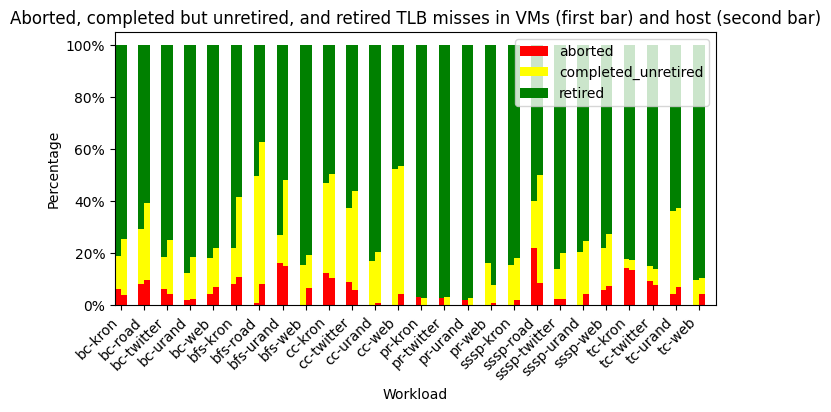

In [4]:
directory_path1 = './perf_output/out2'
directory_path2 = './perf_output/out_vm2'

quantities = ['dtlb_load_misses.miss_causes_a_walk:u', 
            'dtlb_load_misses.pde_cache_miss:u',
            'dtlb_load_misses.walk_completed_4k:u', 
            'mem_uops_retired.stlb_miss_loads:u',
]

final_df = get_final_df(directory_path1, directory_path2, quantities)
final_df = final_df[final_df['event_name'] != 'dtlb_load_misses.pde_cache_miss:u']

final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)
df = final_df.loc[workloads_with_both_vms]

final_df = df.copy()
final_df['mem_uops_retired.stlb_miss_loads:u'] = df['mem_uops_retired.stlb_miss_loads:u']
final_df['dtlb_load_misses.walk_completed_4k:u'] = df['dtlb_load_misses.walk_completed_4k:u'] - df['mem_uops_retired.stlb_miss_loads:u']
final_df['dtlb_load_misses.miss_causes_a_walk:u'] = df['dtlb_load_misses.miss_causes_a_walk:u'] - df['dtlb_load_misses.walk_completed_4k:u']
final_df[final_df < 0] = 0
total = final_df[['mem_uops_retired.stlb_miss_loads:u', 'dtlb_load_misses.walk_completed_4k:u', 'dtlb_load_misses.miss_causes_a_walk:u']].sum(axis=1)
final_df['mem_uops_retired.stlb_miss_loads:u'] /= total.replace(0, 1)
final_df['dtlb_load_misses.walk_completed_4k:u'] /= total.replace(0, 1)
final_df['dtlb_load_misses.miss_causes_a_walk:u'] /= total.replace(0, 1)


final_df = final_df.rename(columns={'dtlb_load_misses.miss_causes_a_walk:u': 'aborted', 'dtlb_load_misses.walk_completed_4k:u': 'completed_unretired', 'mem_uops_retired.stlb_miss_loads:u': 'retired'})
expected_columns = ['aborted', 'completed_unretired', 'retired']
final_df = final_df[expected_columns]


ax = final_df.plot(kind='bar', stacked=True, figsize=(7, 4), color=['red', 'yellow', 'green'])
plt.ylabel('Percentage')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))

plt.tight_layout()
plt.legend()

# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)

plt.title("Aborted, completed but unretired, and retired TLB misses in VMs (first bar) and host (second bar)")
plt.show()


Empty data for ./perf_output/out2/cc-road.1.perf
Empty data for ./perf_output/out_vm2/pr-road.1.perf


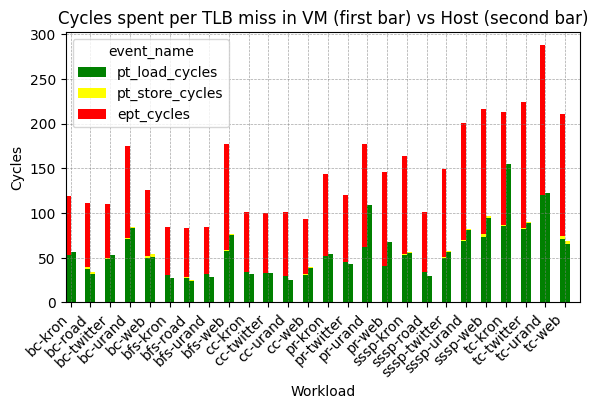

In [5]:
directory_path1 = './perf_output/out2'
directory_path2 = './perf_output/out_vm2'

quantities = ['cycles:u', 
'dtlb_load_misses.pde_cache_miss:u','dtlb_load_misses.walk_completed_4k:u', 
            'dtlb_load_misses.walk_duration:u', 
            'dtlb_store_misses.walk_duration:u',
            'mem_uops_retired.stlb_miss_loads:u',
    'dtlb_load_misses.miss_causes_a_walk:u',
            'ept.walk_cycles:u']


final_df = get_final_df(directory_path1, directory_path2, quantities)
final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
workloads = final_df.index.get_level_values('workload').unique()
workloads_with_both_vms = []
for workload in workloads:
    if ('With VM' in final_df.loc[workload].index) and ('Without VM' in final_df.loc[workload].index):
        workloads_with_both_vms.append(workload)
df = final_df.loc[workloads_with_both_vms]
df.fillna(0, inplace=True)

final_df = df.copy()
load_misses = df['dtlb_load_misses.walk_duration:u']
store_misses = df['dtlb_store_misses.walk_duration:u']
total_misses = load_misses + store_misses
final_df['pt_load_cycles'] = (df['dtlb_load_misses.walk_duration:u'] - df['ept.walk_cycles:u'] * (load_misses / total_misses)) / df['dtlb_load_misses.miss_causes_a_walk:u']
final_df['pt_store_cycles'] = (df['dtlb_store_misses.walk_duration:u'] - df['ept.walk_cycles:u'] * (store_misses / total_misses)) / df['dtlb_load_misses.miss_causes_a_walk:u']
final_df['ept_cycles'] = df['ept.walk_cycles:u'] / df['dtlb_load_misses.miss_causes_a_walk:u']
final_df = final_df[['pt_load_cycles', 'pt_store_cycles', 'ept_cycles']]
ax = final_df.plot(kind='bar', stacked=True, figsize=(6, 4), color=['green', 'yellow', 'red'])

plt.ylabel('Cycles')
plt.xlabel('Workload')
plt.xticks(range(0, len(workloads_with_both_vms)*2, 2), workloads_with_both_vms, rotation=45, ha='right')
plt.tight_layout()

# Remove spacing between every other bar
for i, patch in enumerate(ax.patches):
    if i % 2 == 1:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.75)
    if i % 2 == 0:
        patch.set_width(0.5)
        patch.set_x(patch.get_x() - 0.25)


plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.title("Cycles spent per TLB miss in VM (first bar) vs Host (second bar)")
plt.show()


Empty data for ./perf_output/out2/cc-road.1.perf
Empty data for ./perf_output/out_vm2/pr-road.1.perf
Max Latency: 455.5062290261506


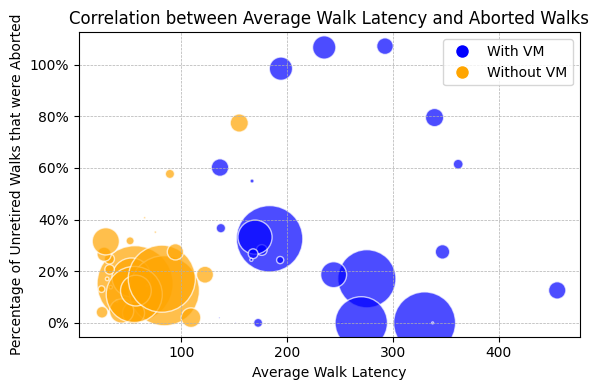

In [6]:
directory_path1 = './perf_output/out2'
directory_path2 = './perf_output/out_vm2'

quantities = [
    'dtlb_load_misses.miss_causes_a_walk:u',
    'dtlb_load_misses.pde_cache_miss:u',
    'dtlb_load_misses.walk_completed_4k:u',
    'dtlb_load_misses.walk_duration:u',
    'ept.walk_cycles:u',
    'mem_uops_retired.stlb_miss_loads:u'
]


final_df = get_final_df(directory_path1, directory_path2, quantities)
final_df = final_df.groupby(['workload', 'vm', 'event_name'])['counter_value'].sum().unstack()
final_df.fillna(0, inplace=True)

# Compute percentage of aborted walks and average walk latency
# final_df['aborted'] = (final_df['dtlb_load_misses.miss_causes_a_walk:u'] - final_df['dtlb_load_misses.walk_completed_4k:u']) / final_df['dtlb_load_misses.miss_causes_a_walk:u']
final_df['aborted'] = (final_df['dtlb_load_misses.miss_causes_a_walk:u'] - final_df['dtlb_load_misses.walk_completed_4k:u']) / (final_df['dtlb_load_misses.miss_causes_a_walk:u']-final_df['mem_uops_retired.stlb_miss_loads:u'])
final_df[final_df < 0] = 0
final_df['avg_walk_latency'] = (final_df['dtlb_load_misses.walk_duration:u'] + final_df['ept.walk_cycles:u']) / final_df['dtlb_load_misses.miss_causes_a_walk:u']
print("Max Latency:", final_df['avg_walk_latency'].max())

# Compute the maximum value across both VM statuses
max_misses_value = (final_df['dtlb_load_misses.miss_causes_a_walk:u']-final_df['mem_uops_retired.stlb_miss_loads:u']).max()

# Plotting the scatter plot
plt.figure(figsize=(6, 4))
for vm_status, color in [('With VM', 'blue'), ('Without VM', 'orange')]:
    subset = final_df.xs(vm_status, level='vm')
    
    # Scaling the size of the circles based on the number of miss_causes_a_walk
    circle_sizes = (subset['dtlb_load_misses.miss_causes_a_walk:u']-subset['mem_uops_retired.stlb_miss_loads:u']) / max_misses_value * 3000  # normalize using the global max and scale
    
    plt.scatter(subset['avg_walk_latency'], subset['aborted'], color=color, s=circle_sizes, label=vm_status, alpha=0.7, edgecolors='w')

plt.title("Correlation between Average Walk Latency and Aborted Walks")
plt.xlabel("Average Walk Latency")
plt.ylabel("Percentage of Unretired Walks that were Aborted")
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# Custom legend
legend_labels = ['With VM', 'Without VM']
legend_colors = ['blue', 'orange']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markerfacecolor=color, markersize=10) for label, color in zip(legend_labels, legend_colors)]

plt.legend(handles=legend_handles)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Processing file 1/29: ./perf_output/out2/pr-road.1.perf
Processing file 2/29: ./perf_output/out2/pr-twitter.1.perf
Processing file 3/29: ./perf_output/out2/bc-urand.1.perf
Processing file 4/29: ./perf_output/out2/cc-kron.1.perf
Processing file 5/29: ./perf_output/out2/sssp-twitter.1.perf
Processing file 6/29: ./perf_output/out2/bfs-kron.1.perf
Processing file 7/29: ./perf_output/out2/sssp-road.1.perf
Processing file 8/29: ./perf_output/out2/pr-web.1.perf
Processing file 9/29: ./perf_output/out2/bfs-road.1.perf
Processing file 10/29: ./perf_output/out2/bc-road.1.perf
Processing file 11/29: ./perf_output/out2/bfs-urand.1.perf
Processing file 12/29: ./perf_output/out2/tc-twitter.1.perf
Processing file 13/29: ./perf_output/out2/bfs-web.1.perf
Processing file 14/29: ./perf_output/out2/sssp-kron.1.perf
Processing file 15/29: ./perf_output/out2/cc-twitter.1.perf
Processing file 16/29: ./perf_output/out2/sssp-urand.1.perf
Processing file 17/29: ./perf_output/out2/bc-web.1.perf
Processing file 

<Figure size 500x300 with 0 Axes>

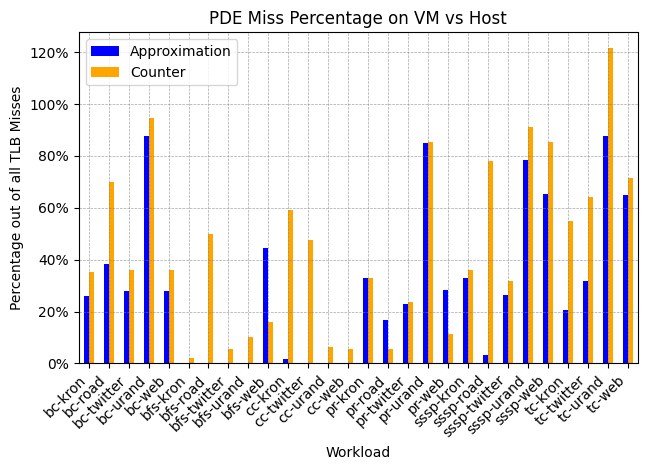

In [7]:

import pandas as pd
import os
import matplotlib.pyplot as plt

def plot_perf_file(filepath, cache_levels, is_vm):
    df = pd.read_csv(filepath, comment='#', header=None, 
                     names=['time', 'counter_value', 'event_name'],
                     usecols=[0, 1, 3])
    cache_df = df[df['event_name'].isin(cache_levels)].copy()
    if cache_df.empty:
        print(f"Empty data for {filepath}")
        return None

    if is_vm:
        # For VM, use the PDE misses to completed walks ratio
        pde_misses = cache_df[cache_df['event_name'] == 'dtlb_load_misses.pde_cache_miss:u']['counter_value'].sum()
        completed_walks = cache_df[cache_df['event_name'] == 'dtlb_load_misses.walk_completed_4k:u']['counter_value'].sum()
        ratio = (pde_misses / completed_walks) if completed_walks != 0 else 0
        label = 'Counter'
    else:
        # For Host, approximate PDE misses by adding walker hits to l1, l2, l3, mem
        walker_hits = cache_df[cache_df['event_name'].str.contains('page_walker_loads.dtlb_l')]['counter_value'].sum() + \
                      cache_df[cache_df['event_name'] == 'page_walker_loads.dtlb_memory:u']['counter_value'].sum()
        miss_causes_walk = cache_df[cache_df['event_name'] == 'dtlb_load_misses.miss_causes_a_walk:u']['counter_value'].sum()
        ratio = max(0, (walker_hits / miss_causes_walk) - 1) if miss_causes_walk != 0 else 0
        label = 'Approximation'

    return pd.DataFrame({
        'workload': os.path.basename(filepath).split('.')[0],
        'label': label,
        'ratio': [ratio]
    })

# Paths and file processing
directory_path = './perf_output/out2'
perf_files = [os.path.join(directory_path, f) for f in os.listdir(directory_path) if f.endswith('.perf')]

quantities = ['dtlb_load_misses.pde_cache_miss:u', 'dtlb_load_misses.miss_causes_a_walk:u', 'dtlb_load_misses.walk_completed_4k:u', 'page_walker_loads.dtlb_l1:u', 'page_walker_loads.dtlb_l2:u', 'page_walker_loads.dtlb_l3:u', 'page_walker_loads.dtlb_memory:u']

dataframes = []
for idx, perf_file in enumerate(perf_files):
    print(f"Processing file {idx + 1}/{len(perf_files)}: {perf_file}")
    df_vm = plot_perf_file(perf_file, quantities, True)
    df_host = plot_perf_file(perf_file, quantities, False)
    if df_vm is not None and df_host is not None:
        dataframes.extend([df_vm, df_host])

# Combining data and plotting
final_df = pd.concat(dataframes)
final_df_grouped = final_df.groupby(['workload', 'label'])['ratio'].mean().unstack()

# Plotting
plt.figure(figsize=(5, 3))
ax = final_df_grouped.plot(kind='bar', stacked=False, color=['blue', 'orange'])
plt.ylabel('Percentage out of all TLB Misses')
plt.xlabel('Workload')
plt.title("PDE Miss Percentage on VM vs Host")
plt.xticks(rotation=45, ha='right')
plt.legend(title='')
plt.tight_layout()
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1))
plt.grid(True, linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.show()